# Mie Scattering of a Lossless Dielectric Sphere

A common reference calculation in computational electromagnetics for which an analytical solution is known is [Mie scattering](https://en.wikipedia.org/wiki/Mie_scattering) which involves computing the [scattering efficiency](http://www.thermopedia.com/content/956/) of a single, homogeneous sphere given an incident planewave. The scattered power of any object (absorbing or non) can be computed by surrounding it with a *closed* [DFT flux](https://meep.readthedocs.io/en/latest/Python_User_Interface/#flux-spectra) box (its size and orientation are irrelevant because of Poynting's theorem) and performing two simulations: (1) a normalization run involving an empty cell to save the incident fields from the source and (2) the scattering run with the object but first subtracting the incident fields in order to obtain just the scattered fields. This approach has already been described in [Transmittance Spectrum of a Waveguide Bend](https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics#transmittance-spectrum-of-a-waveguide-bend).

The scattering cross section is the scattered power in all directions divided by the incident intensity. The scattering efficiency, a dimensionless quantity, is the ratio of the scattering cross section to the cross sectional area of the sphere. In this demonstration, the sphere is a lossless dielectric with wavelength-independent refractive index of 2.0. This way, [subpixel smoothing](https://meep.readthedocs.io/en/latest/Subpixel_Smoothing) can improve accuracy at low resolutions which is important for reducing the size of this 3d simulation. The source is an $E_z$-polarized, planewave pulse (its `size` parameter fills the *entire* cell in 2d) spanning the broadband wavelength spectrum of 10% to 50% the circumference of the sphere. There is one subtlety: since the [planewave source extends into the PML](https://meep.readthedocs.io/en/latest/Perfectly_Matched_Layer/#planewave-sources-extending-into-pml) which surrounds the cell on all sides, `is_integrated=True` must be specified in the source object definition. A `k_point` of zero specifying periodic boundary conditions is necessary in order for the source to be infinitely extended. Also, given the [symmetry of the fields and the structure](https://meep.readthedocs.io/en/latest/Exploiting_Symmetry), two mirror symmery planes can be used to reduce the cell size by a factor of four. The simulation results are validated by comparing with the analytic theory obtained from the [PyMieScatt](https://pymiescatt.readthedocs.io/en/latest/) module (which you will have to install in order to run the script below).

In [13]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import PyMieScatt as ps

r = 1.0  # radius of sphere

wvl_min = 2 * np.pi * r / 10
wvl_max = 2 * np.pi * r / 2

frq_min = 1 / wvl_max
frq_max = 1 / wvl_min
frq_cen = 0.5 * (frq_min + frq_max)
dfrq = frq_max - frq_min
nfrq = 1

## at least 8 pixels per smallest wavelength, i.e. np.floor(8/wvl_min)
resolution = 10

dpml = 0.5 * wvl_max
dair = 0.5 * wvl_max

pml_layers = [mp.PML(thickness=dpml)]

symmetries = [mp.Mirror(mp.Y), mp.Mirror(mp.Z, phase=-1)]

s = 2 * (dpml + dair + r)
cell_size = mp.Vector3(s, s, s)

# is_integrated=True necessary for any planewave source extending into PML
sources = [
    mp.Source(
        mp.GaussianSource(frq_cen, fwidth=dfrq, is_integrated=True),
        center=mp.Vector3(-0.5 * s + dpml),
        size=mp.Vector3(0, s, s),
        component=mp.Ez,
    )
]

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=pml_layers,
    sources=sources,
    k_point=mp.Vector3(),
    symmetries=symmetries,
)

box_x1 = sim.add_flux(
    frq_cen,
    dfrq,
    nfrq,
    mp.FluxRegion(center=mp.Vector3(x=-r), size=mp.Vector3(0, 2 * r, 2 * r)),
)
box_x2 = sim.add_flux(
    frq_cen,
    dfrq,
    nfrq,
    mp.FluxRegion(center=mp.Vector3(x=+r), size=mp.Vector3(0, 2 * r, 2 * r)),
)
box_y1 = sim.add_flux(
    frq_cen,
    dfrq,
    nfrq,
    mp.FluxRegion(center=mp.Vector3(y=-r), size=mp.Vector3(2 * r, 0, 2 * r)),
)
box_y2 = sim.add_flux(
    frq_cen,
    dfrq,
    nfrq,
    mp.FluxRegion(center=mp.Vector3(y=+r), size=mp.Vector3(2 * r, 0, 2 * r)),
)
box_z1 = sim.add_flux(
    frq_cen,
    dfrq,
    nfrq,
    mp.FluxRegion(center=mp.Vector3(z=-r), size=mp.Vector3(2 * r, 2 * r, 0)),
)
box_z2 = sim.add_flux(
    frq_cen,
    dfrq,
    nfrq,
    mp.FluxRegion(center=mp.Vector3(z=+r), size=mp.Vector3(2 * r, 2 * r, 0)),
)

sim.run(until_after_sources=10)

freqs = mp.get_flux_freqs(box_x1)
box_x1_data = sim.get_flux_data(box_x1)
box_x2_data = sim.get_flux_data(box_x2)
box_y1_data = sim.get_flux_data(box_y1)
box_y2_data = sim.get_flux_data(box_y2)
box_z1_data = sim.get_flux_data(box_z1)
box_z2_data = sim.get_flux_data(box_z2)

box_x1_flux0 = mp.get_fluxes(box_x1)

sim.reset_meep()

n_sphere = 2.0
geometry = [
    mp.Sphere(material=mp.Medium(index=n_sphere), center=mp.Vector3(), radius=r)
]

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=pml_layers,
    sources=sources,
    k_point=mp.Vector3(),
    symmetries=symmetries,
    geometry=geometry,
)

box_x1 = sim.add_flux(
    frq_cen,
    dfrq,
    nfrq,
    mp.FluxRegion(center=mp.Vector3(x=-r), size=mp.Vector3(0, 2 * r, 2 * r)),
)
box_x2 = sim.add_flux(
    frq_cen,
    dfrq,
    nfrq,
    mp.FluxRegion(center=mp.Vector3(x=+r), size=mp.Vector3(0, 2 * r, 2 * r)),
)
box_y1 = sim.add_flux(
    frq_cen,
    dfrq,
    nfrq,
    mp.FluxRegion(center=mp.Vector3(y=-r), size=mp.Vector3(2 * r, 0, 2 * r)),
)
box_y2 = sim.add_flux(
    frq_cen,
    dfrq,
    nfrq,
    mp.FluxRegion(center=mp.Vector3(y=+r), size=mp.Vector3(2 * r, 0, 2 * r)),
)
box_z1 = sim.add_flux(
    frq_cen,
    dfrq,
    nfrq,
    mp.FluxRegion(center=mp.Vector3(z=-r), size=mp.Vector3(2 * r, 2 * r, 0)),
)
box_z2 = sim.add_flux(
    frq_cen,
    dfrq,
    nfrq,
    mp.FluxRegion(center=mp.Vector3(z=+r), size=mp.Vector3(2 * r, 2 * r, 0)),
)

sim.load_minus_flux_data(box_x1, box_x1_data)
sim.load_minus_flux_data(box_x2, box_x2_data)
sim.load_minus_flux_data(box_y1, box_y1_data)
sim.load_minus_flux_data(box_y2, box_y2_data)
sim.load_minus_flux_data(box_z1, box_z1_data)
sim.load_minus_flux_data(box_z2, box_z2_data)

sim.run(until_after_sources=100)

box_x1_flux = mp.get_fluxes(box_x1)
box_x2_flux = mp.get_fluxes(box_x2)
box_y1_flux = mp.get_fluxes(box_y1)
box_y2_flux = mp.get_fluxes(box_y2)
box_z1_flux = mp.get_fluxes(box_z1)
box_z2_flux = mp.get_fluxes(box_z2)

scatt_flux = (
    np.asarray(box_x1_flux)
    - np.asarray(box_x2_flux)
    + np.asarray(box_y1_flux)
    - np.asarray(box_y2_flux)
    + np.asarray(box_z1_flux)
    - np.asarray(box_z2_flux)
)
intensity = np.asarray(box_x1_flux0) / (2 * r) ** 2
scatt_cross_section = np.divide(scatt_flux, intensity)
scatt_eff_meep = scatt_cross_section * -1 / (np.pi * r**2)
scatt_eff_theory = [
    ps.MieQ(n_sphere, 1000 / f, 2 * r * 1000, asDict=True)["Qsca"] for f in freqs
]

-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00471997 s
Working in 3D dimensions.
Computational cell is 8.3 x 8.3 x 8.3 with resolution 10
time for set_epsilon = 0.239879 s
-----------


run 0 finished at t = 17.900000000000002 (358 timesteps)
-----------
Initializing structure...
Padding y to even number of grid points.
Padding z to even number of grid points.
Halving computational cell along direction y
Halving computational cell along direction z
time for choose_chunkdivision = 0.00274301 s
Working in 3D dimensions.
Computational cell is 8.3 x 8.3 x 8.3 with resolution 10
     sphere, center = (0,0,0)
          radius 1
          dielectric constant epsilon diagonal = (4,4,4)
time for set_epsilon = 0.816859 s
-----------
Meep progress: 19.75/107.85398149490356 = 18.3% done in 4.0s, 17.9s to go
on time step 395 (time=19.75), 0.0101367 s/step
Meep progress: 45.400000000000006/107.85398149490356 = 42.1% done in 8.0s, 11.0s to go
on time step 908 (time=45.4), 0.00781089 s/step
Meep progress: 68.05/107.85398149490356 = 63.1% done in 12.0s, 7.0s to go
on time step 1361 (time=68.05), 0.00883104 s/step
Meep progress: 92.35000000000001/107.85398149490356 = 85.6% done in 16.0

In [15]:
print("\n--- Scattering Flux Components ---")
print("X1 (−x face):", np.asarray(box_x1_flux))
print("X2 (+x face):", np.asarray(box_x2_flux))
print("Y1 (−y face):", np.asarray(box_y1_flux))
print("Y2 (+y face):", np.asarray(box_y2_flux))
print("Z1 (−z face):", np.asarray(box_z1_flux))
print("Z2 (+z face):", np.asarray(box_z2_flux))

print("\n--- Total Scattered Flux (all directions) ---")
print("Scattered flux:", scatt_flux)

print("\n--- Scattering Flux Components ---")
print("X1 (−x face):", np.sum(box_x1_flux))
print("X2 (+x face):", np.sum(box_x2_flux))
print("Y1 (−y face):", np.sum(box_y1_flux))
print("Y2 (+y face):", np.sum(box_y2_flux))
print("Z1 (−z face):", np.sum(box_z1_flux))
print("Z2 (+z face):", np.sum(box_z2_flux))





--- Scattering Flux Components ---
X1 (−x face): [-0.02441197]
X2 (+x face): [0.16885463]
Y1 (−y face): [-0.01295171]
Y2 (+y face): [0.01295171]
Z1 (−z face): [-0.01379685]
Z2 (+z face): [0.01379685]

--- Total Scattered Flux (all directions) ---
Scattered flux: [-0.24676373]

--- Scattering Flux Components ---
X1 (−x face): -0.02441197018049715
X2 (+x face): 0.16885463033753262
Y1 (−y face): -0.012951714614752748
Y2 (+y face): 0.012951714614752748
Z1 (−z face): -0.013796852389295034
Z2 (+z face): 0.013796852389295034


In [19]:
np.size(box_x1_flux)
box_x1_flux
wvl_min
#wvl_max
frq_cen

0.9549296585513721

In [6]:
# Calculate total scattered flux (sum over all wavelengths)
total_scattered_flux = np.sum(scatt_flux)

# Print per-wavelength flux and total
print("\n--- Scattered Flux at Each Wavelength ---")
for i, val in enumerate(scatt_flux):
    print(f"Wavelength {i+1:02d}: {val:.6f}")

print("\n--- Total Scattered Flux Over All Monitors ---")
print(f"Total Scattered Flux: {total_scattered_flux:.6f}")



--- Scattered Flux at Each Wavelength ---
Wavelength 01: -0.000004
Wavelength 02: -0.000008
Wavelength 03: -0.000012
Wavelength 04: -0.000014
Wavelength 05: -0.000020
Wavelength 06: -0.000030
Wavelength 07: -0.000039
Wavelength 08: -0.000059
Wavelength 09: -0.000107
Wavelength 10: -0.000156
Wavelength 11: -0.000175
Wavelength 12: -0.000230
Wavelength 13: -0.000317
Wavelength 14: -0.000397
Wavelength 15: -0.000475
Wavelength 16: -0.000671
Wavelength 17: -0.001244
Wavelength 18: -0.001150
Wavelength 19: -0.001216
Wavelength 20: -0.001677
Wavelength 21: -0.002600
Wavelength 22: -0.003168
Wavelength 23: -0.003616
Wavelength 24: -0.007113
Wavelength 25: -0.006835
Wavelength 26: -0.007533
Wavelength 27: -0.009688
Wavelength 28: -0.016030
Wavelength 29: -0.024489
Wavelength 30: -0.027159
Wavelength 31: -0.040508
Wavelength 32: -0.045966
Wavelength 33: -0.053661
Wavelength 34: -0.062985
Wavelength 35: -0.077761
Wavelength 36: -0.121833
Wavelength 37: -0.127073
Wavelength 38: -0.158605
Wavelen

The incident intensity (`intensity`) is the flux in one of the six monitor planes (the one closest to and facing the planewave source propagating in the $x$ direction) divided by its area. This is why the six sides of the flux box are defined separately. (Otherwise, the entire box could have been defined as a single flux object with different weights ±1 for each side.) The scattered power is multiplied by -1 since it is the *outgoing* power (a positive quantity) rather than the incoming power as defined by the orientation of the flux box. Note that because of the linear $E_z$ polarization of the source, the flux through the $y$ and $z$ planes will *not* be the same. A circularly-polarized source would have produced equal flux in these two monitor planes. The runtime of the scattering run is chosen to be sufficiently long to ensure that the Fourier-transformed fields have [converged](https://meep.readthedocs.io/en/latest/FAQ/checking-convergence).

Results are shown below. Overall, the Meep results agree well with the analytic theory.

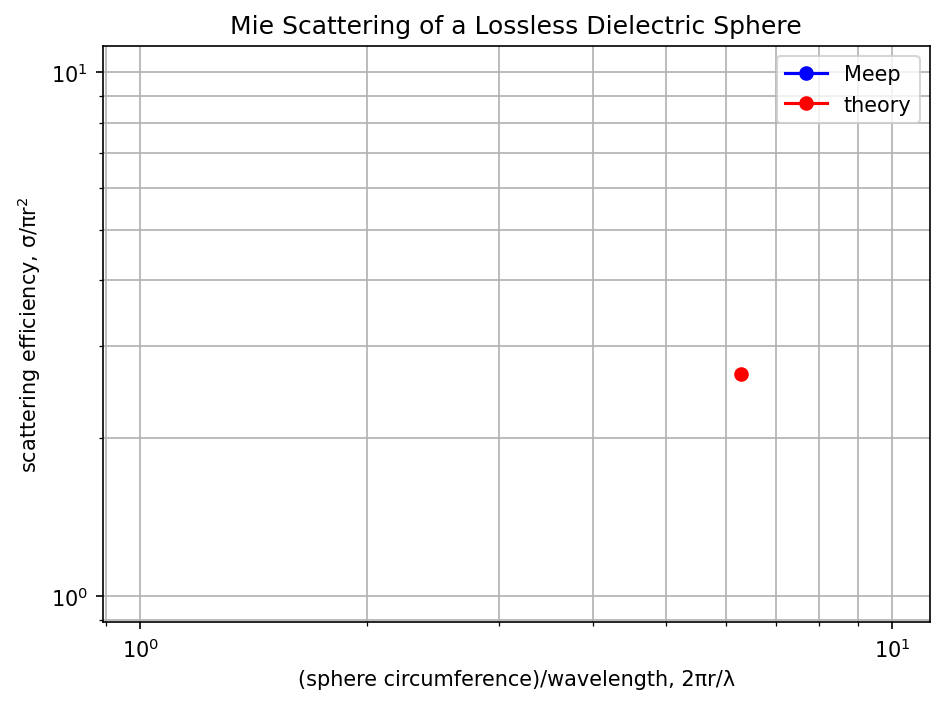

In [10]:
plt.figure(dpi=150)
plt.loglog(2 * np.pi * r * np.asarray(freqs), scatt_eff_meep, "bo-", label="Meep")
plt.loglog(2 * np.pi * r * np.asarray(freqs), scatt_eff_theory, "ro-", label="theory")
plt.grid(True, which="both", ls="-")
plt.xlabel("(sphere circumference)/wavelength, 2πr/λ")
plt.ylabel("scattering efficiency, σ/πr$^{2}$")
plt.legend(loc="upper right")
plt.title("Mie Scattering of a Lossless Dielectric Sphere")
plt.tight_layout()
plt.show()

![](https://meep.readthedocs.io/en/latest/images/mie_scattering.png)

Finally, for the case of a *lossy* dielectric material (i.e. complex refractive index) with non-zero absorption, the procedure to obtain the scattering efficiency is the same. The absorption efficiency is the ratio of the absorption cross section to the cross sectional area of the sphere. The absorption cross section is the total absorbed power divided by the incident intensity. The absorbed power is simply flux into the same box as for the scattered power, but *without* subtracting the incident field (and with the opposite sign, since absorption is flux *into* the box and scattering is flux *out of* the box): omit the `load_minus_flux_data` calls.